# Мера контрастности tf-idf для выделения ключевых слов. Векторная модель текста. Снижение размерности в векторной модели. Совсем простой поиск


## Мера контрастности $tf-idf$ для выделения ключевых слов

Рассмотрим коллекцию текстов о ягуарах. Ягуар – это омоним, имеет несколько значений: животное, название напитка, название автомобильной марки, название фильма и модель швейной машины. На каждое из 5 значений слова у нас есть по 5 текстов. Для каждого из 5 значений слова мы можем найти в коллекции свои, специфические слова. 

Для начала объединим каждые 5 текстов в один текст, получим коллекцию из 5 текстов, каждый посвящен своему значению. 

In [4]:
path = '../data/jaguar'
raw_collection = []
for i in range(1,6):
    cur_path = path + str(i) + '/'
    cur_collection = []
    for j in range(1,6):
        lines = open(cur_path+str(j)+'.txt', encoding='utf8').readlines()
        cur_collection.append(lines[0])
    merged_text = ' '.join(cur_collection)
    print(merged_text[:100])
    raw_collection.append(merged_text)
print(len(raw_collection))

Ягуар (Panthera onca) — вид хищных млекопитающих семейства кошачьих, один из четырёх представителей 
Jaguar (напиток) Jaguar Слабоалкогольный газированный энергетический напиток Алюминиевая банка напит
Британская автомобилестроительная компания Jaguar Cars производит легковые автомобили Jaguar класса 
Франсис Вебер — это знаковая фигура во французском, да и в европейском кино в общем. Посудите сами: 
Инструкция для швейной машины Mini Jaguar Инструкция швейной машины Mini Jaguar Швейная машинка "Мин
5


Проведем стандартную предобработку.

In [6]:
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer

exclude = set(punctuation + u'0123456789[]—«»–')

from pymorphy2 import MorphAnalyzer

def preprocess(text):
    buf = ''.join(ch for ch in text if ch not in exclude)
    tokens = WhitespaceTokenizer().tokenize(buf.lower())
    lemmatizer = MorphAnalyzer()
    lemmas = []
    for t in tokens[:]:
        if not t in stopwords.words('russian'):
            try:
                lemma = lemmatizer.parse(t)[0].normal_form
            except: 
                lemma = t
#             print t, type(t), lemma
            lemmas.append(lemma)
    return lemmas

# lemmatizer = MorphAnalyzer()    
# print lemmatizer.parse(u'фильмы')[0].normal_form 
collection = [preprocess(text) for text in raw_collection]

Используем реализации $tf-idf$ из NLTK для поиска ключевых слов в каждом тексте. Существенный недостаток этой реализации – скорость.

In [26]:
from nltk.text import TextCollection
from nltk.corpus import stopwords 

cur_text = 1
buf = []
corpus = TextCollection(collection)
for i in set(collection[cur_text]):
    buf.append([ i, corpus.tf_idf(i, collection[cur_text])])
for i in sorted(buf,key=lambda l:l[1], reverse=True)[:20]:
    print(i[0], i[1])

метр 0.024713587517693304
плавать 0.019770870014154642
пятно 0.01889750973503836
мощный 0.017931325476989335
лапа 0.016596974843053548
леопард 0.015747924779198633
чёрный 0.014946759402891047
нередко 0.01482815251061598
туловище 0.01482815251061598
обитание 0.012598339823358905
река 0.012598339823358905
прирождённый 0.012598339823358905
рассказывать 0.012598339823358905
широта 0.012598339823358905
крапинка 0.012598339823358905
вода 0.012598339823358905
рыба 0.012447731132290162
огромный 0.012447731132290162
вес 0.010758795286193602
приходиться 0.010758795286193602


# Векторная модель текста

Вернемся к исходным 25 текстам и снова проведем стандартную обработку. 

In [9]:
path = '../data/jaguar'
raw_collection = []
for i in range(1,6):
    cur_path = path + str(i) + '/'
    for j in range(1,6):
        lines = open(cur_path+str(j)+'.txt', encoding='utf8').readlines()
        raw_collection.append(lines[0])
print(len(raw_collection))
collection = [preprocess(text) for text in raw_collection]

25


Теперь вычислим косинусную меру сходства между всеми текстами с помощью библиотеки gensim.

In [28]:
from gensim import corpora, models, similarities
import numpy as np

dictionary = corpora.Dictionary(collection)
corpus = [dictionary.doc2bow(t) for t in collection]
tfidf = models.TfidfModel(corpus) 
corpus_tfidf = tfidf[corpus]
print(corpus_tfidf)

In [29]:
index = similarities.MatrixSimilarity(tfidf[corpus])
sims = index[corpus_tfidf]
print(np.around(sims, decimals = 2))

[[ 1.          0.22        0.40000001  0.31        0.25        0.04        0.04
   0.05        0.03        0.05        0.03        0.02        0.03        0.03
   0.01        0.05        0.03        0.01        0.03        0.05        0.01
   0.01        0.02        0.02        0.04      ]
 [ 0.22        1.          0.22        0.28999999  0.18000001  0.01        0.03
   0.03        0.02        0.02        0.01        0.01        0.01        0.02
   0.01        0.02        0.03        0.02        0.02        0.04        0.01
   0.03        0.01        0.02        0.03      ]
 [ 0.40000001  0.22        1.          0.34        0.23999999  0.02        0.02
   0.03        0.01        0.02        0.01        0.01        0.01        0.02
   0.01        0.02        0.02        0.01        0.02        0.03        0.01
   0.01        0.01        0.01        0.03      ]
 [ 0.31        0.28999999  0.34        1.          0.22        0.02        0.02
   0.03        0.01        0.02        0.01    

Так как сама по себе матрица не очень понятна, построим по ней диаграмму близости. 

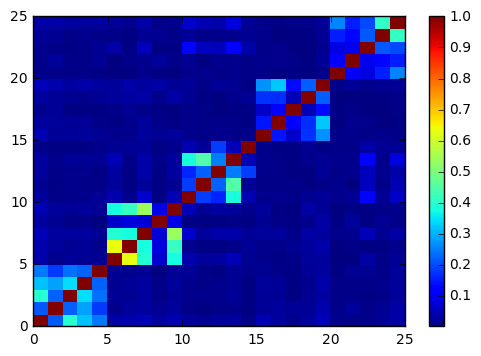

In [12]:
from pylab import pcolor, show, colorbar, xticks, yticks
%matplotlib inline

pcolor(sims)
colorbar()
show()

А теперь используем ЛСА, снизим количество размерностей до 10, пересчитаем и перерисуем матрицу близости.

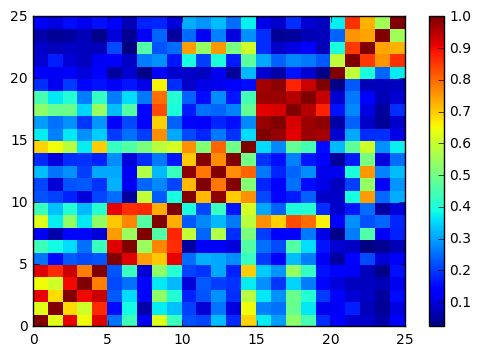

In [13]:
lsi = models.LsiModel(corpus, num_topics=10) 
corpus_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[corpus_lsi]
pcolor(sims)
colorbar()
show()

# Задание 1

Создайте собственную коллекцию текстов. Найдите ключевые слова для каждого текста по мере $tf-idf$. Объясните принцип создания коллекции и полученные результаты. 

# Задание 2

Найдите ключевые биграммы для каждого текста по мере $tf-idf$. 


# Литература

* Manning & Raghavan & Schütze (IRbook) – Ch. 6.2.2 – Tf-idf weighting (http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html)

* Manning & Raghavan & Schütze (IRbook) – Ch. 18 – Matrix decompositions and latent semantic indexing

* NLTK (плохая документация):  http://www.nltk.org/api/nltk.html#nltk.text.TextCollection

* http://www.tfidf.com/

* Gensim (документация и туториал): https://radimrehurek.com/gensim/

# Совсем простой поиск

In [30]:
doc = u"машина"
vec_bow = dictionary.doc2bow(preprocess(doc))
vec_tfidf = tfidf[vec_bow] 
sims = index[vec_tfidf]
sim_list = sorted(enumerate(sims), key=lambda item: -item[1])
for i in sim_list:
    if i[1] > 0:
        print(i)

(22, 0.31049913)
(20, 0.082851298)
(14, 0.06384252)
(24, 0.061500318)
(21, 0.05592959)
(12, 0.026284507)
(23, 0.024860036)
(11, 0.020495294)
(10, 0.018246267)
(13, 0.012472699)


In [31]:
doc = u"хороший ягуар"
vec_bow = dictionary.doc2bow(preprocess(doc))
vec_tfidf = tfidf[vec_bow] 
sims = index[vec_tfidf]
sim_list = sorted(enumerate(sims), key=lambda item: -item[1])
for i in sim_list:
    if i[1] > 0:
        print(i)

(12, 0.04919038)
(21, 0.049018715)
(0, 0.026228026)
(2, 0.025527325)
(8, 0.024278589)
(13, 0.023342146)
(18, 0.021240572)
(19, 0.020806178)
(15, 0.018771263)
(24, 0.013058485)
(1, 0.012685684)
(6, 0.01104558)
(23, 0.010894117)
(4, 0.010166726)
(3, 0.0085646911)
(9, 0.0082896547)
(5, 0.0042626057)
(14, 0.0037854419)
(10, 0.0028850231)
(20, 0.0026609576)
(17, 0.0025049341)
(16, 0.0017894759)
(11, 0.0016203149)


# Тематические модели

In [16]:
lsi = models.lsimodel.LsiModel(corpus=corpus, id2word=dictionary, num_topics = 10)
for topic in lsi.print_topics(5):
    print(topic)
    print('***')

(0, '0.605*"ягуар" + 0.244*"год" + 0.194*"напиток" + 0.144*"jaguar" + 0.137*"который" + 0.133*"нитка" + 0.128*"человек" + 0.127*"свой" + 0.116*"это" + 0.113*"швейный"')
***
(1, '-0.351*"нитка" + -0.265*"швейный" + -0.242*"машинка" + -0.233*"лапка" + 0.231*"ягуар" + -0.213*"машина" + -0.184*"строчка" + -0.175*"шпулька" + -0.139*"верхний" + -0.136*"положение"')
***
(2, '0.379*"фильм" + -0.317*"ягуар" + 0.265*"вебер" + 0.241*"это" + 0.184*"свой" + 0.170*"герой" + 0.164*"который" + 0.135*"перрен" + 0.118*"ришар" + 0.116*"дуэт"')
***
(3, '-0.472*"напиток" + -0.284*"jaguar" + -0.255*"год" + 0.208*"фильм" + 0.146*"вебер" + 0.144*"нитка" + -0.142*"модель" + 0.134*"ягуар" + -0.123*"компания" + 0.111*"свой"')
***
(4, '0.512*"напиток" + 0.202*"нитка" + -0.198*"год" + -0.171*"модель" + -0.134*"машинка" + -0.132*"jaguar" + 0.120*"шпулька" + -0.117*"компания" + 0.112*"положение" + -0.107*"автомобиль"')
***


In [17]:
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics = 15)
for topic in lda.print_topics(5):
    print(topic)
    print('***')

(14, '0.020*"напиток" + 0.015*"ягуар" + 0.011*"год" + 0.010*"jaguar" + 0.006*"человек" + 0.006*"один" + 0.006*"это" + 0.004*"который" + 0.004*"свой" + 0.004*"нитка"')
***
(9, '0.014*"ягуар" + 0.013*"год" + 0.010*"швейный" + 0.009*"машина" + 0.008*"jaguar" + 0.006*"иметь" + 0.005*"модель" + 0.005*"который" + 0.005*"нитка" + 0.004*"машинка"')
***
(10, '0.016*"ягуар" + 0.006*"год" + 0.006*"это" + 0.005*"напиток" + 0.005*"свой" + 0.004*"который" + 0.003*"человек" + 0.003*"алкоголь" + 0.003*"модель" + 0.003*"нитка"')
***
(12, '0.029*"ягуар" + 0.011*"напиток" + 0.006*"нитка" + 0.005*"человек" + 0.005*"год" + 0.004*"это" + 0.004*"который" + 0.004*"очень" + 0.003*"jaguar" + 0.003*"свой"')
***
(2, '0.018*"ягуар" + 0.008*"год" + 0.006*"напиток" + 0.005*"jaguar" + 0.005*"один" + 0.004*"время" + 0.004*"самка" + 0.004*"чёрный" + 0.003*"который" + 0.003*"крупный"')
***
